In [1]:
# Import stuff
import numpy as np
import matplotlib.pyplot as pl
import os, pickle
import random

import smarty
from copy import deepcopy
from smarty import *
from smarty import forcefield
from samplingtools import *
import openeye
from openeye import oechem
from smarty.utils import get_data_filename

In [3]:
%matplotlib inline

/Users/guilhermematos/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py:43: DeprecationWarning: IPythonKernel._eventloop_changed is deprecated: use @observe and @unobserve instead.
  def _eventloop_changed(self, name, old, new):


In [4]:
# Functions
def calculate_energies(smirk, key,
                       modify_key_by_type,
                       prange, number_of_points,
                       copyff, oemol, topology):
    xaxis = np.linspace(prange[key][0],prange[key][1], number_of_points)
    energies = np.zeros(len(xaxis))
    params = copyff.getParameter(smirks=smirk)
    backup = params.copy()
    for idx, element in enumerate(xaxis):
        params[key] = str(element)
        copyff.setParameter(params,smirks=smirk)
        system = copyff.createSystem(topology, [oemol])
        cpos = reformat_oemol_coordinates(oemol)
        energies[idx] = get_energy(system,cpos[:,:,0])
    return xaxis, energies

def plot_data(xaxis,yaxis,legend,smirks_tuple,yaxis_name):
    fig = pl.figure(figsize=(3.25,3.25))
    ax = fig.add_subplot(111)
    ax.plot(xaxis,yaxis,'bo',label=legend)
    ax.set_xlabel(key)
    ax.set_ylabel(yaxis_name)
    if smirks_tuple[1] > 35:
        title = smirks_tuple[1][:35]+'\n'+smirks_tuple[1][35:]
    else:
        title = smirks_tuple[1]
    ax.set_title(title,fontsize=10)
    pl.tight_layout()
    pl.savefig("%s_%s_%s.pdf" % (smirks_tuple[0],key,yaxis_name))
    pl.close(fig)
    return

def gaussian(mean, std, x):
    y = (1/(std *np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mean)/std)**2)
    return y

def log_likelihood( z, mu, s_E):
    """Calculate a log likelihood and a likelihood given a calculated value, a set of `measured`/observed values
        (data we are fitting to) and a standard error in those measured values.
        
        
        Parameters
        ----------
        z : simtk.unit.Quantity of dimensions N
        Calculated values
        mu : simtk.unit.Quantity of dimensions N
        Mean (i.e. observed/measured values)
        s_E : simtk.unit.Quantity of dimensions N
        Standard error in the mean (uncertainty in observed/measured values)
        
        Returns
        -------
        loglike : float
        Natural logarithm of likelihood
        like : float
        Likelihood
        """
    # Adapted from https://github.com/shirtsgroup/lj_bayesian/blob/041b896d37f91f4b42cccb2df73af84a9cf5b917/generate_posterior.py#L117
    
    
    # Standardize units of input and strip units, if they have units
    try:
        unit_choice = z.unit
        clear_s_E = s_E.value_in_unit(unit_choice)
        clear_mu = mu.value_in_unit(unit_choice)
        clear_z = z.value_in_unit(unit_choice)
    except AttributeError:
        clear_s_E = s_E
        clear_mu = mu
        clear_z = z
    # If we've mixed things with units with things without units, the below will raise another attribute error
    
    # Compute log likelihood and likelihood
    # Gaussian is (2*pi*s_E^2)^(-1/2) e^(-(z-mu)^2 /2s_E^2)
    # log Gaussian is -1/2 * (log(2*pi) + 2*log(s_E)) -|z-mu|^2/(2s_E^2)
    # Here we will ignore the constant term because it drops out when taking ratios of probabilities
    loglike = 0.
    like = 0.
    for i, m in enumerate(clear_mu):
        this_s_E = clear_s_E[i]
        this_z = clear_z[i]
        gauss_arg = - ((m-this_z)**2)/(2.*this_s_E**2)
        loglike += gauss_arg - 0.5*np.log(2*np.pi*this_s_E**2)
    
    like = np.exp(loglike)
    return loglike, like

In [5]:
# Load pre-generated data if already generated, otherwise re-generate
if os.path.isfile('ref_energies.pickle') and os.path.isfile('topologies.pickle') and os.path.isfile('oemols_molnames.pickle'):
    file = open('ref_energies.pickle', 'r')
    ref_energies = pickle.load(file)
    file.close()
    file = open('topologies.pickle', 'r')
    topologies = pickle.load(file)
    file = open('oemols_molnames.pickle', 'r')
    oemols, mol_names = pickle.load(file)
    file.close()
    print("Loaded reference data.")
else:
    print("Re-generating reference data.")
    os.system('python generate_reference_data.py')
    file = open('ref_energies.pickle', 'r')
    ref_energies = pickle.load(file)
    file.close()
    file = open('topologies.pickle', 'r')
    topologies = pickle.load(file)
    file = open('oemols_molnames.pickle', 'r')
    oemols, mol_names = pickle.load(file)
    file.close()
    print("Loaded reference data.")

if os.path.isfile('s_E_mean.pickle'):
    file = open('s_E_mean.pickle', 'r')
    s_E, mean_unc = pickle.load(file)
    file.close()
else:
    print("Re-generating uncertainty data.")
    os.system('python get_uncertainties.py')
    file = open('s_E_mean.pickle', 'r')
    s_E, mean_unc = pickle.load(file)
    file.close()

Loaded reference data.


In [98]:
# Get force field data, parameter types, ranges and smirk labels
# Get force field
ffxml = get_data_filename('forcefield/Frosst_AlkEtOH.ffxml')
ff = forcefield.ForceField(ffxml)
# Define parameter range to consider
prange = {'rmin_half':[0.0, 5.], 'epsilon':[0.0, 1.0], 'length':[0.0,2.0], 'k':[0.,2000.], 'angle':[0.,180.]}
# What keys to modify for each smirks
modify_key_by_type = {'n':['rmin_half', 'epsilon'],'b':['length', 'k'], 'a':['angle','k'],'t':['k','periodicity','phase'], 'i':['k','periodicity','phase']}
# Figure out how to determine which molecules use the SMIRKS we're interested in
labels = ff.labelMolecules(oemols,verbose=False)
# Define molecule of interest
mol =  oemols[1]
top = topologies[1]
mu_E = ref_energies[1] # mean_unc is the associated uncertainty
# Create copy of the force field
copyff = deepcopy(ff)
copyff2 = deepcopy(ff)

In [99]:
molecule = pd.DataFrame.from_dict(labels[1],orient='index')
molecule

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
HarmonicBondGenerator,"([1, 2], b0001, [#6X4:1]-[#6X4:2])","([2, 5], b0004, [#6X4:1]-[#8&X2&H1:2])","([5, 13], b0006, [#8X2:1]-[#1:2])","([3, 11], b0006, [#8X2:1]-[#1:2])","([0, 7], b0002, [#6X4:1]-[#1:2])","([2, 10], b0002, [#6X4:1]-[#1:2])","([0, 6], b0002, [#6X4:1]-[#1:2])","([1, 8], b0002, [#6X4:1]-[#1:2])","([4, 12], b0006, [#8X2:1]-[#1:2])","([1, 9], b0002, [#6X4:1]-[#1:2])",...,None,None,None,None,None,None,None,None,None,None
PeriodicTorsionGenerator,"([5, 2, 0, 7], t0012, [#1:1]-[#6X4:2]-[#6X4:3]...","([7, 0, 3, 11], t0002, [a,A:1]-[#6X4:2]-[#8X2:...","([1, 2, 0, 7], t0005, [#1:1]-[#6X4:2]-[#6X4:3]...","([4, 1, 2, 5], t0010, [#8X2:1]-[#6X4:2]-[#6X4:...","([5, 2, 1, 8], t0012, [#1:1]-[#6X4:2]-[#6X4:3]...","([0, 2, 1, 9], t0005, [#1:1]-[#6X4:2]-[#6X4:3]...","([6, 0, 2, 10], t0004, [#1:1]-[#6X4:2]-[#6X4:3...","([4, 1, 2, 10], t0012, [#1:1]-[#6X4:2]-[#6X4:3...","([8, 1, 4, 12], t0002, [a,A:1]-[#6X4:2]-[#8X2:...","([3, 0, 2, 5], t0010, [#8X2:1]-[#6X4:2]-[#6X4:...",...,"([9, 1, 4, 12], t0002, [a,A:1]-[#6X4:2]-[#8X2:...","([5, 2, 1, 9], t0012, [#1:1]-[#6X4:2]-[#6X4:3]...","([5, 2, 0, 6], t0012, [#1:1]-[#6X4:2]-[#6X4:3]...","([1, 2, 0, 6], t0005, [#1:1]-[#6X4:2]-[#6X4:3]...","([1, 2, 0, 3], t0001, [a,A:1]-[#6X4:2]-[#6X4:3...","([3, 0, 2, 10], t0012, [#1:1]-[#6X4:2]-[#6X4:3...","([0, 2, 1, 8], t0005, [#1:1]-[#6X4:2]-[#6X4:3]...","([6, 0, 3, 11], t0002, [a,A:1]-[#6X4:2]-[#8X2:...","([2, 1, 4, 12], t0006, [#6X4:1]-[#6X4:2]-[#8X2...","([10, 2, 5, 13], t0002, [a,A:1]-[#6X4:2]-[#8X2..."
NonbondedGenerator,"([0], n0008, [#6X4:1])","([1], n0008, [#6X4:1])","([2], n0008, [#6X4:1])","([8], n0003, [$([#1]-[#6]-[#7,#8,#9,#16,#17,#3...","([3], n0011, [#8X2+0$(*-[#1]):1])","([9], n0003, [$([#1]-[#6]-[#7,#8,#9,#16,#17,#3...","([4], n0011, [#8X2+0$(*-[#1]):1])","([10], n0003, [$([#1]-[#6]-[#7,#8,#9,#16,#17,#...","([5], n0011, [#8X2+0$(*-[#1]):1])","([11], n0006, [#1$(*-[#8]):1])",...,None,None,None,None,None,None,None,None,None,None
HarmonicAngleGenerator,"([1, 4, 12], a0005, [#6X4:1]-[#8X2:2]-[#1:3])","([3, 0, 7], a0001, [a,A:1]-[#6X4:2]-[a,A:3])","([2, 0, 3], a0001, [a,A:1]-[#6X4:2]-[a,A:3])","([2, 5, 13], a0005, [#6X4:1]-[#8X2:2]-[#1:3])","([4, 1, 8], a0001, [a,A:1]-[#6X4:2]-[a,A:3])","([8, 1, 9], a0002, [#1:1]-[#6X4:2]-[#1:3])","([2, 0, 7], a0001, [a,A:1]-[#6X4:2]-[a,A:3])","([0, 3, 11], a0005, [#6X4:1]-[#8X2:2]-[#1:3])","([2, 1, 8], a0001, [a,A:1]-[#6X4:2]-[a,A:3])","([4, 1, 9], a0001, [a,A:1]-[#6X4:2]-[a,A:3])",...,"([5, 2, 10], a0001, [a,A:1]-[#6X4:2]-[a,A:3])","([0, 2, 1], a0003, [#6X4:1]-[#6X4:2]-[#6X4:3])","([3, 0, 6], a0001, [a,A:1]-[#6X4:2]-[a,A:3])","([1, 2, 5], a0001, [a,A:1]-[#6X4:2]-[a,A:3])",None,None,None,None,None,None


In [100]:
params = copyff.getParameter(smirks='[#6X4:1]')
backup = params.copy()
parm_table = pd.DataFrame.from_dict(params,orient='index')
parm_table.columns = ['property']
parm_table

,property
parent_id,n0007
smirks,[#6X4:1]
id,n0008
epsilon,0.1094
rmin_half,1.9080


In [101]:
# calculate variables to be plotted
epsilons, E_eps = calculate_energies('[#6X4:1]', 'epsilon',
                       modify_key_by_type,
                       prange, 300,
                       copyff, mol, top)

rmin_halfs, E_rhs = calculate_energies('[#6X4:1]', 'rmin_half',
                       modify_key_by_type,
                       prange, 300,
                       copyff2, mol, top)


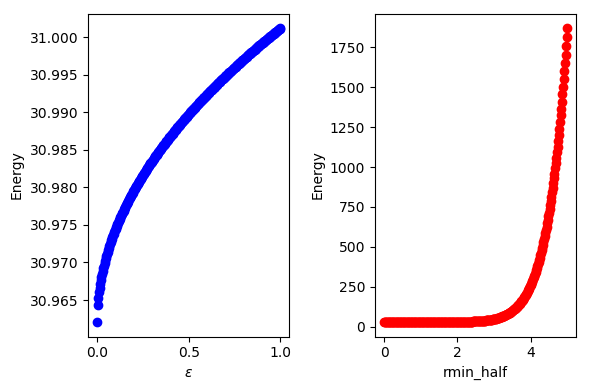

In [102]:
# Plot energies
fig = pl.figure()

ax1 = fig.add_subplot(121)
ax1.plot(epsilons, E_eps, 'bo')
ax1.set_xlabel(r'$\epsilon$')
ax1.set_ylabel('Energy')

ax2 = fig.add_subplot(122)
ax2.plot(rmin_halfs, E_rhs, 'ro')
ax2.set_xlabel(r'rmin_half')
ax2.set_ylabel('Energy')

pl.tight_layout()

In [103]:
# Calculate likelihoods
# Storage
likelihood_eps = np.zeros(len(epsilons))
likelihood_rhs = np.zeros(len(rmin_halfs))

# likelihood distribution of bond lengths
for idx, energy in enumerate(E_eps):
    loglike, like = log_likelihood([energy],[mu_E],[mean_unc])
    likelihood_eps[idx] = like
    
# likelihood distribution of bond ks
for idx, energy in enumerate(E_rhs):
    loglike, like = log_likelihood([energy],[mu_E],[mean_unc])
    likelihood_rhs[idx] = like

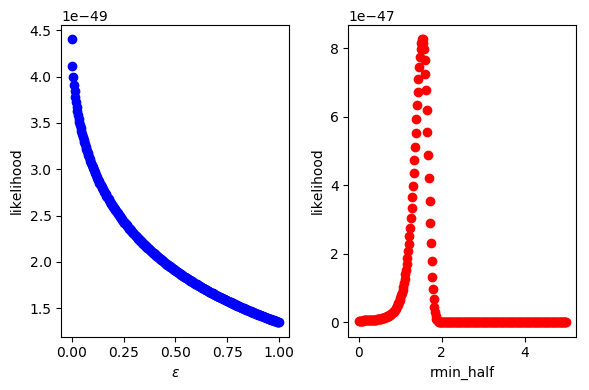

In [104]:
# Plot likelihoods
fig = pl.figure()

ax1 = fig.add_subplot(121)
ax1.plot(epsilons, likelihood_eps, 'bo')
ax1.set_xlabel(r'$\epsilon$')
ax1.set_ylabel('likelihood')

ax2 = fig.add_subplot(122)
ax2.plot(rmin_halfs, likelihood_rhs, 'ro')
ax2.set_xlabel(r'rmin_half')
ax2.set_ylabel('likelihood')

pl.tight_layout()

In [26]:
en_axis = np.linspace(mu_E-3*mean_unc,mu_E+3*mean_unc,200)
likelihoods = gaussian(mu_E,mean_unc,en_axis)

In [105]:
np.argmax(likelihood_rhs,axis=0)

92

In [106]:
rmin_halfs[153]

2.5585284280936453